# Train-Synthetic-Test-Real

In this tutorial, we show how to assess synthetic data quality with respect to its utility for a downstream Machine Learning (ML) task. The demonstrated approach is also known as the Train-Synthetic-Test-Real (TSTR) evaluation [[1](#refs)]. It is a strong test for the quality of generated synthetic data, as machine learning models require deeper hidden structures being faithfully represented in order to be effective on new unseen data. Thus, it can serve as a stronger test than relying merely on assessing higher-level statistics. 

See image below for the general setup of TSTR.

<img src='./TSTR.png' width="600px"/>

Thus, we take actual (=real) data, and split it into a holdout and a training dataset. Next, we create a synthetic dataset only based on the training data. Then we train a Machine Learning (ML) model, and do so once using the synthetic data and once using the actual training data. And finally we evaluate the performance of each of those two models on top of the actual holdout data, that was kept aside all along. By comparing the performance of these two models, we can assess how much utility has been retained by the synthesization method with respect to a specific ML task.

Note, that one needs to use a true holdout for the evaluation to properly measure out-of-sample performance, as this is the relevant metric for real-world use cases. If one uses the same training data that has been used for the synthesis, one would "leak" information from training into evaluation. This becomes particularly an issue for synthesizers that are prone to overfitting, and simply memorize the samples that it has been exposed to. If one, on the other hand, were to use synthetic data for the evaluation, one would not get meaningful results either, as the synthetic data might not be representative of the real data. E.g., consider the degenerate case of a synthesizer that only produces the same record over and over again. Any model trained on that data, would yield perfect results when evaluated on it again, whereas it will be of no use when applied to real data.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using a cleaned up version of the UCI Adult Income [[2](#refs)] dataset, that itself stems from the 1994 American Community Survey [[3](#refs)] by the US census bureau. The dataset consists of 48,842 records, 14 mixed-type features and has 1 target variable, that indicates whether a respondent had or had not reported a high level of annual income. This dataset is being selected, as it's one of the go-to datasets commonly used to showcase machine learning models in action.

1. Download `census-training.csv` from [here](./census-training.csv). This is an 80% sample of the full dataset. The remaining 20% sample can be fetched from [here](./census-holdout.csv).

2. Synthesize `census-training.csv` via [MOSTLY AI](https://mostly.ai/). You can leave all settings at their default, and just proceed to launch job.

<img src='./screen1.png' width="400px"/> <img src='./screen2.png' width="400px"/><br /><img src='./screen3.png' width="400px"/> <img src='./screen4.png' width="400px"/>

3. Once the job has finished, download the generated synthetic data as CSV file to your computer.

4. Upload the generated synthetic data to this Notebook via executing the next cell.


In [1]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    print("running in LOCAL mode")
    print("adapt `syn_file_path` to point to your generated synthetic data file")
    syn_file_path = './census-synthetic.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

running in LOCAL mode
adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 39,074 records and 15 attributes


In [2]:
# fetch training and holdout data directly from S3 bucket
repo = 'https://github.com/mostly-ai/mostly-tutorials/raw/dev/train-synthetic-test-real'
train = pd.read_csv(f'{repo}/census-training.csv')
print(f'fetched training data with {train.shape[0]:,} records and {train.shape[1]} attributes')
holdout = pd.read_csv(f'{repo}/census-holdout.csv')
print(f'fetched holdout data with {holdout.shape[0]:,} records and {holdout.shape[1]} attributes')

fetched training data with 39,074 records and 15 attributes
fetched holdout data with 9,768 records and 15 attributes


In [3]:
# show first few actual samples
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,23,Private,203139,Some-college,10,Never-married,Other-service,Other-relative,White,Female,0,0,40,United-States,<=50K
1,62,Private,196891,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
2,26,?,109564,HS-grad,9,Never-married,?,Own-child,White,Female,0,0,40,United-States,<=50K
3,45,Private,348854,Some-college,10,Separated,Adm-clerical,Unmarried,White,Female,0,0,27,United-States,<=50K
4,39,Private,89040,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K


In [4]:
# show first few synthetic samples
syn.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,26,Private,279630,7th-8th,4,Never-married,Craft-repair,Own-child,Other,Male,0,0,70,Dominican-Republic,<=50K
1,38,Private,251329,11th,7,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
2,24,Private,280871,HS-grad,9,Never-married,Other-service,Other-relative,White,Male,0,0,34,United-States,<=50K
3,32,Private,257960,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States,<=50K
4,32,Self-emp-not-inc,220133,Bachelors,13,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,35,United-States,<=50K


As you can see, the synthetic data is structurally identical to the actual data, but differs in content.

## Compare ML Performance

We use a state-of-the-art **LightGBM** classifier as our downstream ML model, and train it for the task of predicting the `income` column, based on all other 14 features. Thus, given the `age`, `education`, `marital-status`, etc. information on a subject, we intend to predict whether that person reported an annual income of more than $50K or not.

In [5]:
# define ML model training pipeline, including data preparation, model training, and model evaluation

import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

target_col = 'income'
target_val = '>50K'

# prepare data, and split into features `X` and target `y`
def prepare_xy(df):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

# train ML model with early stopping
def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    print(f"X_trn: {X_trn.shape[0]:,} rows, {X_trn.shape[1]:,} columns, target: {y_trn.mean():.2%}")
    print(f"X_val: {X_val.shape[0]:,} rows, {X_val.shape[1]:,} columns, target: {y_val.mean():.2%}")
    model = lgb.train(
        num_boost_round=20,
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

# apply ML Model to some holdout data, report key metrics, and visualize scores
def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    acc = accuracy_score(y_hol, preds)
    print("")
    print(f"Holdout Accuracy: {acc:.1%}")
    print(f"Holdout AUC:      {auc:.3f}")
    print("")
    print("Confusion Matrix")
    print(pd.crosstab(pd.Series(preds, name='predicted'), y_hol))
    print("")
    probs_df = pd.concat([
        pd.Series(probs, name='probability').reset_index(drop=True),
        pd.Series(y_hol, name='target').reset_index(drop=True)
    ], axis=1)
    fig = sns.displot(data=probs_df, x='probability', hue='target', bins=20, palette=['#008CFB', '#FF004F'])
    fig = plt.title(f"Holdout AUC: {auc:.3f}", fontsize = 20)
    plt.show()
    return auc

import warnings
warnings.filterwarnings('ignore')

### Train ML Model on Real Data: `model_trn`


In [6]:
X_trn, y_trn = prepare_xy(train)
model_trn = train_model(X_trn, y_trn)

X_trn: 31,259 rows, 14 columns, target: 23.79%
X_val: 7,815 rows, 14 columns, target: 24.50%
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.921486


### Train ML Model on Synthetic Data: `model_syn`

In [7]:
X_syn, y_syn = prepare_xy(syn)
model_syn = train_model(X_syn, y_syn)

X_trn: 31,259 rows, 14 columns, target: 24.50%
X_val: 7,815 rows, 14 columns, target: 24.71%
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.904592


### Evaluate `model_trn` on actual holdout


Holdout Accuracy: 86.7%
Holdout AUC:      0.921

Confusion Matrix
income        0     1
predicted            
0          7070   935
1           361  1402



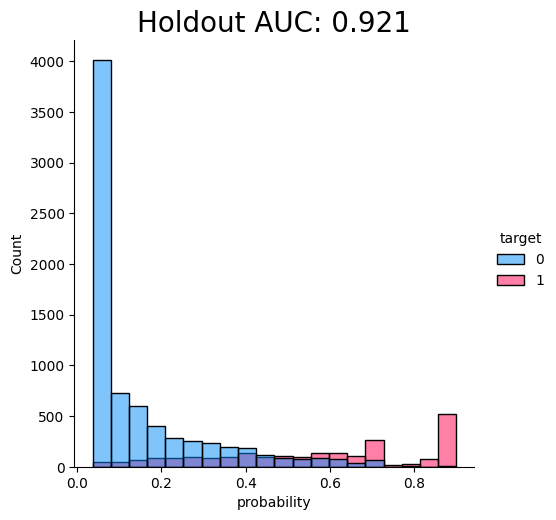

In [8]:
auc_trn = evaluate_model(model_trn, holdout)

### Evaluate `model_syn` on actual holdout


Holdout Accuracy: 86.1%
Holdout AUC:      0.916

Confusion Matrix
income        0     1
predicted            
0          7027   949
1           404  1388



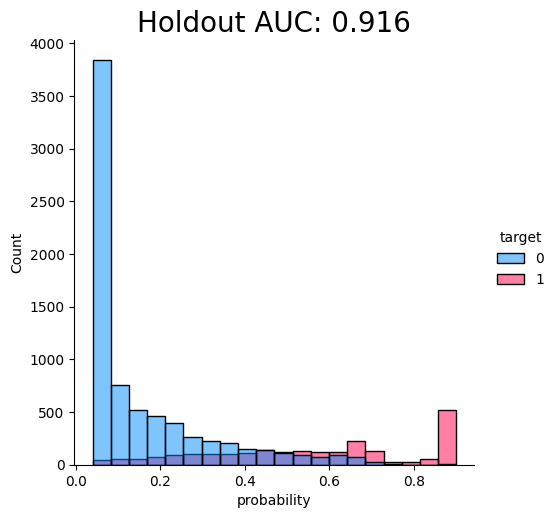

In [9]:
auc_syn = evaluate_model(model_syn, holdout)

In [10]:
print(f"The closer the AUC for synthetic is to actual, the better the synthesis.")
print(f"Area-Under-Curve (AUC) for ML model trained on actual data is:    {auc_trn:.3f}")
print(f"Area-Under-Curve (AUC) for ML model trained on synthetic data is: {auc_syn:.3f}")

The closer the AUC for synthetic is to actual, the better the synthesis.
Area-Under-Curve (AUC) for ML model trained on actual data is:    0.921
Area-Under-Curve (AUC) for ML model trained on synthetic data is: 0.916


## Conclusion

For the given dataset, and the given synthesizer, we can observe a near on-par performance of the synthetic data with respect to the given downstream ML task. This means, that one can train the model purely on synthetic data, and yield just as good results as if it were trained on real data, but without ever putting the privacy of any of the contained individuals at any risk.

## Further exercises

In addition to walking through the above instructions, we suggest..
* to run Train-Synthetic-Test-Real 
  * using a different dataset, eg. the UCI bank-marketing dataset [[4](#refs)]
  * using a different downstream ML model, eg. a RandomForest model [[5](#refs)]
  * using a different synthesizer, eg. SynthCity, SDV, etc.
* to check the impact of synthetic upsampling
  * generate 10x or 100x the original data records, and see whether it improves ML accuracy

## References<a class="anchor" name="refs"></a>

1. https://arxiv.org/pdf/1706.02633.pdf §3.1.2
1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://www.census.gov/programs-surveys/acs
1. https://archive.ics.uci.edu/ml/datasets/bank+marketing
1. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Extras: Data Preparation

The following code snippet can be used to split a DataFrame into a training and a holdout dataset

In [11]:
from sklearn.model_selection import train_test_split

df = pd.DataFrame({'x': range(10), 'y': range(10, 20)})
df_trn, df_hol = train_test_split(df, test_size=0.2, random_state=1)
display(df_trn)
display(df_hol)

,x,y
6,6,16
4,4,14
0,0,10
3,3,13
1,1,11
7,7,17
8,8,18
5,5,15


,x,y
2,2,12
9,9,19
